In [1]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [3]:
def augment_images(folder_path):
  # flips image 3 times
  for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
      img_path = os.path.join(folder_path, filename)
      try:
        img = Image.open(img_path)

        # Horizontal flip
        h_flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        h_flipped_img.save(os.path.join(folder_path, f"hflip_{filename}"))

        # Vertical flip
        v_flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
        v_flipped_img.save(os.path.join(folder_path, f"vflip_{filename}"))

        hv_flipped_img = v_flipped_img
        hv_flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        hv_flipped_img.save(os.path.join(folder_path, f"hvflip_{filename}"))

      except IOError:
        print(f"Error opening or processing image: {filename}")

# Example usage (replace 'path/to/your/image/folder' with the actual path)
augment_images("dataset")


In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.02):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [3]:
class AnimeDataset(Dataset):
    def __init__(self, image_paths, augment=False):
        self.image_paths = image_paths
        self.augment = augment

        # When augmentation is enabled, apply random horizontal flip,
        # random affine translation, random cropping (not fixed to the center),
        # brightness adjustment, and add a little Gaussian noise.
        if self.augment:
            self.aug_transform = transforms.Compose([
                transforms.RandomCrop((256, 256)),
                transforms.ColorJitter(brightness=0.2),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02)
            ])

        # For both training and non-training, use separate transforms to create low‑res and high‑res images.
        # These transforms are applied after augmentation (if any).
        self.low_res_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])
        self.high_res_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.augment:
            # Apply augmentation; note that the aug_transform returns a tensor.
            img_aug = self.aug_transform(img)
            # Convert back to a PIL image so that we can use the resize transforms.
            img_aug_pil = transforms.ToPILImage()(img_aug)
            low_res = self.low_res_transform(img_aug_pil)
            high_res = self.high_res_transform(img_aug_pil)
        else:
            low_res = self.low_res_transform(img)
            high_res = self.high_res_transform(img)
        return low_res, high_res

In [4]:
# Create list of image paths and split into train/validation/test sets.
image_dir = 'dataset'  # Update with your image folder
all_image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)
                   if img.endswith('.jpg') or img.endswith('.png')]
random.shuffle(all_image_paths)
total_size = len(all_image_paths)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size+val_size]
test_paths = all_image_paths[train_size+val_size:]

# Use augmentation only on training data.
train_dataset = AnimeDataset(train_paths, augment=True)
val_dataset = AnimeDataset(val_paths, augment=False)
test_dataset = AnimeDataset(test_paths, augment=False)

train_loader = DataLoader(train_dataset, batch_size=175, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=150, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=150, shuffle=False)

In [5]:
class VAE_UNet(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_UNet, self).__init__()
        # ----------------------
        # Encoder (Downsampling)
        # ----------------------
        # Block 1: 64x64 -> 32x32
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # output: 32x32
            nn.ReLU(inplace=True)
        )
        # Block 2: 32x32 -> 16x16
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # output: 16x16
            nn.ReLU(inplace=True)
        )
        # Block 3: 16x16 -> 8x8
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # output: 8x8
            nn.ReLU(inplace=True)
        )
        # Block 4: 8x8 -> 4x4 (bottleneck)
        self.enc4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # output: 4x4
            nn.ReLU(inplace=True)
        )
        
        # Fully connected layers for VAE latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        # ----------------------
        # Decoder (Upsampling)
        # ----------------------
        # Decoder block 1: 4x4 -> 8x8
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # output: 8x8
            nn.ReLU(inplace=True)
        )
        # Process concatenated features (dec1 + encoder block 3)
        self.dec1_conv = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # Decoder block 2: 8x8 -> 16x16
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # output: 16x16
            nn.ReLU(inplace=True)
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # Decoder block 3: 16x16 -> 32x32
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # output: 32x32
            nn.ReLU(inplace=True)
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv2d(32 + 32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # Extra upsampling blocks to upscale from 32x32 to 256x256
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.ReLU(inplace=True)
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.ReLU(inplace=True)
        )
        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),   # 128x128 -> 256x256
            nn.Sigmoid()  # assuming output is normalized in [0, 1]
        )

    def encode(self, x):
        # x: [B, 3, 64, 64]
        e1 = self.enc1(x)   # [B, 32, 32, 32]
        e2 = self.enc2(e1)  # [B, 64, 16, 16]
        e3 = self.enc3(e2)  # [B, 128, 8, 8]
        e4 = self.enc4(e3)  # [B, 256, 4, 4]
        # Flatten and compute latent variables
        e4_flat = e4.view(e4.size(0), -1)
        mu = self.fc_mu(e4_flat)
        logvar = self.fc_logvar(e4_flat)
        # Return skip connections for U-Net (we use e1, e2, e3)
        return mu, logvar, [e1, e2, e3]

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skip_connections):
        # Project latent vector back to bottleneck feature map shape
        d = self.fc_decode(z)
        d = d.view(-1, 256, 4, 4)
        # Decoder block 1: upsample to 8x8
        d = self.dec1(d)  # [B, 128, 8, 8]
        # Concatenate with encoder block 3 output (skip connection)
        # skip_connections[2] has shape [B, 128, 8, 8]
        d = torch.cat([d, skip_connections[2]], dim=1)  # [B, 256, 8, 8]
        d = self.dec1_conv(d)  # [B, 128, 8, 8]

        # Decoder block 2: upsample to 16x16
        d = self.dec2(d)  # [B, 64, 16, 16]
        # Concatenate with encoder block 2 output (skip connection)
        # skip_connections[1] has shape [B, 64, 16, 16]
        d = torch.cat([d, skip_connections[1]], dim=1)  # [B, 128, 16, 16]
        d = self.dec2_conv(d)  # [B, 64, 16, 16]

        # Decoder block 3: upsample to 32x32
        d = self.dec3(d)  # [B, 32, 32, 32]
        # Concatenate with encoder block 1 output (skip connection)
        # skip_connections[0] has shape [B, 32, 32, 32]
        d = torch.cat([d, skip_connections[0]], dim=1)  # [B, 64, 32, 32]
        d = self.dec3_conv(d)  # [B, 32, 32, 32]

        # Extra upsampling blocks to reach 256x256
        d = self.dec4(d)  # 32x32 -> 64x64, channels: 32
        d = self.dec5(d)  # 64x64 -> 128x128, channels: 16
        d = self.dec6(d)  # 128x128 -> 256x256, channels: 3
        return d

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skips)
        return recon, mu, logvar

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_UNet(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar, beta=100000000.0):
    # Calculate L1 loss without summing over the batch dimension.
    l1_loss = F.l1_loss(recon_x, x, reduction='sum')
    # Compute KLD loss per image:
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    # Optionally, average the KLD over the number of latent dimensions:
    # kld_loss = kld_loss / mu.size(1)
    
    # Total loss per image:
    total_loss = l1_loss + beta * kld_loss
    return total_loss.mean(), l1_loss.mean(), kld_loss.mean()


In [ ]:
num_epochs = 200
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_kld = 0.0
    total_images = 0
    total_l1 = 0

    for low_res, high_res in train_loader:
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        optimizer.zero_grad()
        
        recon, mu, logvar = model(low_res)
        loss, l1, kld = loss_function(recon, high_res, mu, logvar)
        loss.backward()
        optimizer.step()
        
        batch_size = low_res.size(0)
        total_images += batch_size
        total_loss += loss.item() * batch_size
        total_l1 += l1.item() * batch_size
        total_kld += kld.item() * batch_size

    avg_loss = total_loss / total_images
    avg_l1 = total_l1 / total_images
    avg_kld = total_kld / total_images

    print(f"Epoch {epoch+1}: Average Loss per Image: {avg_loss:.4f}, L1: {avg_l1:.4f}, KLD: {avg_kld:.4f}")



    val_total_loss = 0.0
    val_total_l1 = 0.0
    val_total_kld = 0.0
    val_total_images = 0

    model.eval()
    with torch.no_grad():
        for low_res, high_res in val_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            recon, mu, logvar = model(low_res)
            loss, l1, kld = loss_function(recon, high_res, mu, logvar)
            
            batch_size = low_res.size(0)
            val_total_loss += loss.item() * batch_size
            val_total_l1 += l1.item() * batch_size
            val_total_kld += kld.item() * batch_size
            val_total_images += batch_size

    avg_val_loss = val_total_loss / val_total_images
    avg_val_l1 = val_total_l1 / val_total_images
    avg_val_kld = val_total_kld / val_total_images

    print(f"Epoch {epoch+1} | Validation Loss per Image: {avg_val_loss:.4f}, L1: {avg_val_l1:.4f}, KLD: {avg_val_kld:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'VAE_best.pth')
        print("Saved new best model.")

    save_frequency = 10  # Save every 5 epochs
    if (epoch + 1) % save_frequency == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, f'VAE_epoch_{epoch+1}.pth')
        print(f"Saved checkpoint for epoch {epoch+1}")

Epoch 1: Average Loss per Image: 10775330.7500, L1: 9720648.2500, KLD: 0.0105
Epoch 1 | Validation Loss per Image: 8483849.0000, L1: 8359406.0000, KLD: 0.0012
Saved new best model.
Epoch 2: Average Loss per Image: 9802451.7500, L1: 9718038.2500, KLD: 0.0008
Epoch 2 | Validation Loss per Image: 8343014.5000, L1: 8295097.0000, KLD: 0.0005
Saved new best model.
Epoch 3: Average Loss per Image: 9637197.0000, L1: 9606985.5000, KLD: 0.0003
Epoch 3 | Validation Loss per Image: 8063372.0000, L1: 8052155.5000, KLD: 0.0001
Saved new best model.


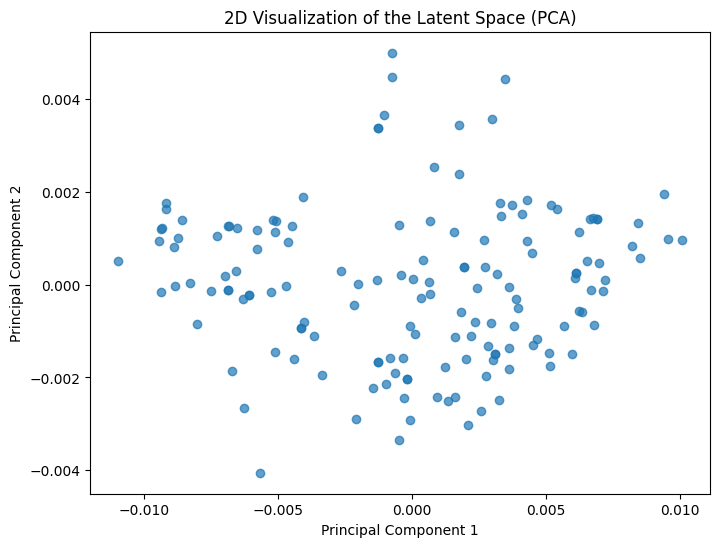

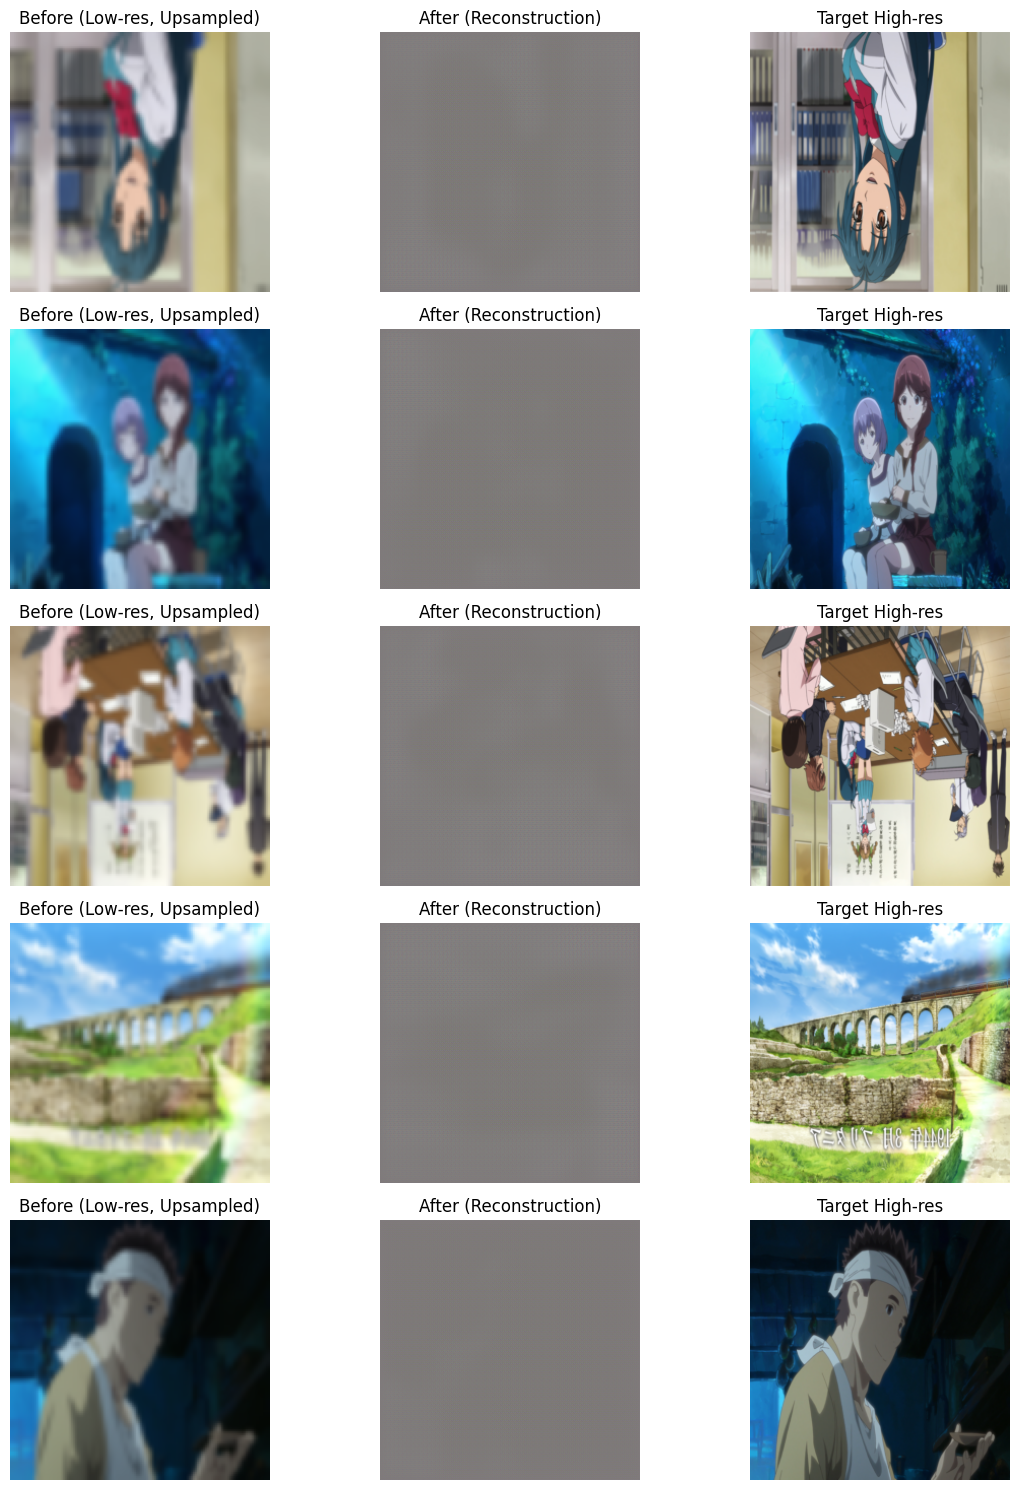

In [40]:
# Load the best model after training
model.load_state_dict(torch.load('VAE_best.pth', weights_only=True))


# Visualize the latent space using PCA on test images.
model.eval()
latents = []
with torch.no_grad():
    for low_res, _ in test_loader:
        low_res = low_res.to(device)
        mu, logvar, _ = model.encode(low_res)  # now unpacking three values
        latents.append(mu.cpu().numpy())

latents = np.concatenate(latents, axis=0)
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("2D Visualization of the Latent Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Show "before and after" on some test images:
with torch.no_grad():
    low_res_batch, high_res_batch = next(iter(test_loader))
    low_res_batch = low_res_batch.to(device)
    high_res_batch = high_res_batch.to(device)
    recon_batch, _, _ = model(low_res_batch)
    # Upsample low-res inputs for a fair display comparison
    low_res_upsampled = F.interpolate(low_res_batch, size=(128, 128), mode='bilinear', align_corners=False)

    low_res_np = low_res_upsampled.cpu().numpy()
    recon_np = recon_batch.cpu().numpy()
    high_res_np = high_res_batch.cpu().numpy()

num_images = min(5, low_res_np.shape[0])
fig, axes = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))
for i in range(num_images):
    axes[i, 0].imshow(np.transpose(low_res_np[i], (1, 2, 0)))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Before (Low-res, Upsampled)")

    axes[i, 1].imshow(np.transpose(recon_np[i], (1, 2, 0)))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("After (Reconstruction)")

    axes[i, 2].imshow(np.transpose(high_res_np[i], (1, 2, 0)))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Target High-res")

plt.tight_layout()
plt.show()